# Laplace on MNIST

## Setup data and model and train it

We start the tutorial by downloading and setting up a dataloader for `MNIST`. We will use a simple `flax.nnx` model for the training. The data + model setup and training closely follows the `flax.nnx` [documentation](https://flax.readthedocs.io/en/latest/mnist_tutorial.html) to stress the flexible post-hoc abilities of `laplax` (and, of course, Laplace Approximations in general).

In [2]:
from itertools import islice

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the random seed for reproducibility
torch.manual_seed(0)

# Define constants
train_steps = 2200
eval_every = 200
train_batch_size = 32
val_batch_size = 32

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load MNIST datasets
train_dataset = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)


# Create data loaders
def collate_fn(batch):
    input, target = (
        torch.stack([s[0] for s in batch]),
        torch.tensor([s[1] for s in batch]),
    )
    return {"input": input.permute(0, 2, 3, 1).numpy(), "target": target.numpy()}


train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=torch.cuda.is_available(),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=val_batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True,
    pin_memory=torch.cuda.is_available(),
)


# Create training iterator that yields for exactly train_steps
train_iter = islice(train_loader, train_steps)
num_training_samples = len(train_dataset)

In [3]:
from functools import partial

import jax
from flax import nnx


class CNN(nnx.Module):
    """A simple CNN model."""

    def __init__(self, *, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.conv2 = nnx.Conv(32, 32, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.conv3 = nnx.Conv(32, 64, kernel_size=(3, 3), padding="VALID", rngs=rngs)
        self.avg_pool1 = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.avg_pool2 = partial(nnx.avg_pool, window_shape=(3, 3), strides=(1, 1))
        self.linear1 = nnx.Linear(64, 10, rngs=rngs)

    def __call__(self, x):
        x = self.avg_pool1(nnx.relu(self.conv1(x)))
        x = self.avg_pool1(nnx.relu(self.conv2(x)))
        x = self.avg_pool2(nnx.relu(self.conv3(x)))
        x = x.flatten()
        x = self.linear1(x)
        return x


# Instantiate the model
model = CNN(rngs=nnx.Rngs(0))


# Create forward function with vmap
@nnx.vmap(in_axes=(None, 0), out_axes=0)
def forward(model: CNN, x):
    return model(x)


# Visualize it
# nnx.display(model)

### Setup optimizer

In [4]:
import optax

learning_rate = 3e-4
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss"),
)

### Setup training step functions

In [5]:
def loss_fn(model: CNN, batch):
    logits = forward(model, batch["input"])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["target"]
    ).mean()
    return loss, logits


@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["target"])  # In-place updates
    optimizer.update(grads)  # In-place updates


@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch["target"])  # In-place updates

### Training the model

In [6]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
}

for step, batch in enumerate(train_iter):
    # Run the optimization for one step and make a stateful update to the following:
    # - The train state's model parameters
    # - The optimizer state
    # - The training loss and accuracy batch metrics
    train_step(model, optimizer, metrics, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.

        # Compute the metrics on the test set after each training epoch.
        for test_batch in test_loader:
            eval_step(model, metrics, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f"test_{metric}"].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        print(
            f"[train] step: {step}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] step: {step}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[train] step: 200, loss: 1.5579794645309448, accuracy: 55.89241409301758
[test] step: 200, loss: 0.7797021865844727, accuracy: 80.3084945678711
[train] step: 400, loss: 0.5934110879898071, accuracy: 83.96875
[test] step: 400, loss: 0.4328945279121399, accuracy: 87.77043151855469
[train] step: 600, loss: 0.39908072352409363, accuracy: 88.609375
[test] step: 600, loss: 0.34474286437034607, accuracy: 89.60336303710938
[train] step: 800, loss: 0.3232814371585846, accuracy: 91.0
[test] step: 800, loss: 0.27154627442359924, accuracy: 92.26762390136719
[train] step: 1000, loss: 0.290798157453537, accuracy: 91.8125
[test] step: 1000, loss: 0.26191624999046326, accuracy: 92.61819458007812
[train] step: 1200, loss: 0.26427599787712097, accuracy: 92.765625
[test] step: 1200, loss: 0.23378585278987885, accuracy: 93.20913696289062
[train] step: 1400, loss: 0.22146792709827423, accuracy: 93.5625
[test] step: 1400, loss: 0.20244349539279938, accuracy: 94.12059020996094
[train] step: 1600, loss: 0.231

## Check model calibration

So far, we have followed along the standard MNIST tutorial from `flax.nnx`. Now, we want to check the calibration of the model, i.e. whether the probabilities it assigns to each class label represents its confidence. A good score for this is the ECE (see e.g. [Mucsányi2023](https://trustworthyml.io/)).

Accuracy: 0.9418


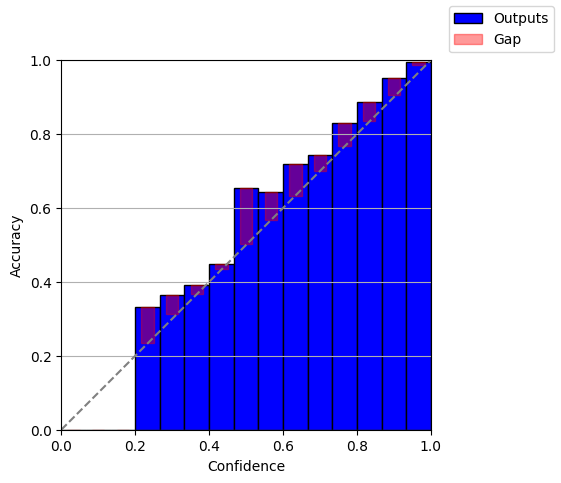

<Figure size 640x480 with 0 Axes>

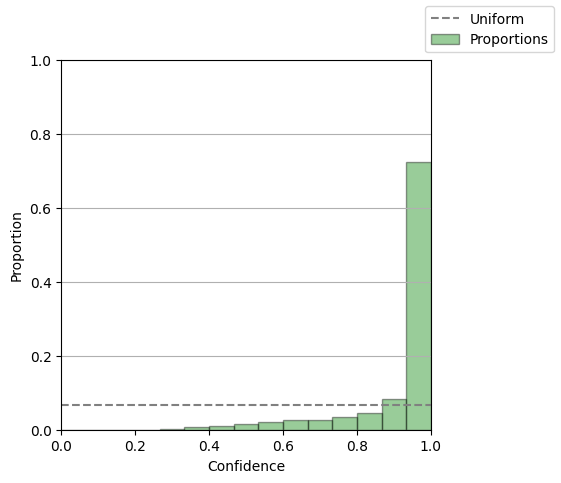

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
%matplotlib inline
import jax.numpy as jnp
from plotting import create_proportion_diagram, create_reliability_diagram

from laplax.eval.metrics import calculate_bin_metrics, correctness

NUM_BINS = 15

# Collect predictions and targets from test dataset
all_predictions = []
all_targets = []


for batch in test_loader:
    # Get predictions for this batch
    predictions = jax.nn.softmax(forward(model, batch["input"]), axis=1)
    all_predictions.append(predictions)
    all_targets.append(batch["target"])


# Concatenate all batches
predictions = jnp.concatenate(all_predictions, axis=0)
targets = jnp.concatenate(all_targets, axis=0)

# Calculate confidence and correctness
max_prob = predictions.max(axis=-1)
correctness_float = correctness(pred=predictions, target=targets).astype(jnp.float32)

print(f"Accuracy: {correctness_float.mean():.4f}")

# Calculate bin metrics
bin_proportions, bin_confidences, bin_accuracies = calculate_bin_metrics(
    confidence=max_prob, correctness=correctness_float, num_bins=NUM_BINS
)

# Plot the reliability diagram
create_reliability_diagram(
    bin_confidences=bin_confidences,
    bin_accuracies=bin_accuracies,
    num_bins=NUM_BINS,
)

# Plot the proportion diagram
create_proportion_diagram(
    bin_proportions=bin_proportions,
    num_bins=NUM_BINS,
)

## Apply Laplace Approximation

First, we create the GGN matrix-vector product. As the GGN has 679,730,993,764 entries in this case, the naive representation of the dense matrix would take approximately 2.718 TB of VRAM. Therefore, it is crucial to represent this matrix-vector product _implicitly_, as shown below.

In [8]:
from laplax.curv import create_ggn_mv

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = next(iter(train_loader))
ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="cross_entropy",
    num_total_samples=num_training_samples,
)

Alternatively, we can consider the `ggn_mv` over a dataloader instead of a single training batch. To do so, the following cell needs to be commented out.

In [9]:
from laplax.curv.ggn import create_ggn_mv_without_data
from laplax.util.loader import DataLoaderMV, reduce_add


# Set maximum number of batches
class LimitedLoader:
    """DataLoader wrapper that limits the number of batches."""

    def __init__(self, loader, max_batches):
        self.loader = loader
        self.max_batches = max_batches

    def __iter__(self):
        batch_iter = iter(self.loader)
        for _ in range(self.max_batches):
            yield next(batch_iter)

    def __len__(self):
        return self.max_batches


NUM_OF_BATCHES = 4
train_loader_limited = LimitedLoader(train_loader, NUM_OF_BATCHES)

# Setup batch-wise GGN-matrix-vector product
ggn_mv_wo_data = create_ggn_mv_without_data(
    model_fn,
    params,
    loss_fn="cross_entropy",
    factor=num_training_samples / (train_batch_size * NUM_OF_BATCHES),
)

# Setup ggn_mv with DataLoader
ggn_mv = DataLoaderMV(
    ggn_mv_wo_data,
    train_loader_limited,
    transform=lambda x: x,
    reduce=reduce_add,
    verbose_logging=True,  # Shows progress bar when iterating through data loader.
)

Callables such as `to_dense`, `diagonal` and `wrap_function` are lowered into the sum of the `DataLoaderMV`. The cell below can be executed if the model above is made sufficiently small such that the GGN fits into memory. 

**Note:** For the remainder of the notebook, we assume an un-wrapped mv function.

In [10]:
# from laplax.util.flatten import create_pytree_flattener, wrap_function
# from laplax.util.mv import to_dense
# from laplax.util.tree import get_size

# flatten, unflatten = create_pytree_flattener(params)
# ggn_mv = wrap_function(ggn_mv, input_fn=unflatten, output_fn=flatten)
# arr = to_dense(ggn_mv, layout=get_size(params))

Next, we use the GGN matrix-vector product above to obtain a low-rank approximation of the GGN. Even though the dense GGN cannot be represented in memory, its low-rank approximation for a sufficiently low rank remains tractable to hold in memory. Having access to the low-rank GGN terms, we can then efficiently invert an isotropically dampened version of it which is the weight-space covariance matrix of our Laplace approximation.

In [11]:
from laplax.curv.cov import create_posterior_fn

# Create Posterior
posterior_fn = create_posterior_fn(
    "lanczos",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(0),
    maxiter=100,
    mv_jit=True,  # If the loader has side effects, such as i/o operations, then
    # this should be set to False.
)

Processing batches: 100%|██████████| 4/4 [00:00<00:00,  8.78it/s]


Finally, we need a way to represent the model's uncertainty in its output space, as decisions (such as abstaining from prediction) are made based on the model output, not on the weight space.

In [12]:
from laplax.eval.metrics import expected_calibration_error
from laplax.eval.pushforward import (
    lin_mc_pred_act,
    lin_pred_mean,
    lin_setup,
    set_lin_pushforward,
)

prior_arguments = {"prior_prec": 10000.0}
pushforward_fns = [
    lin_setup,
    lin_pred_mean,
    lin_mc_pred_act,
]

pushforward_fn = set_lin_pushforward(
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    pushforward_fns=pushforward_fns,
    key=jax.random.key(0),
    num_samples=30,
)

# Set up two versions of the pushforward function - with and without vmap.
pushforward_fn_jit = jax.jit(pushforward_fn)
pushforward_fn_jit_vmap = jax.jit(jax.vmap(pushforward_fn))


# Define the metrics function (ideally with batch dimension)
def confidences_map(map_, **kwargs):
    del kwargs
    return jnp.max(jax.nn.softmax(map_, axis=-1), axis=-1)


def confidences_pred(pred_act, **kwargs):
    del kwargs
    return jnp.max(pred_act, axis=-1)

In [13]:
from laplax.eval import apply_fns, evaluate_metrics_on_generator, transfer_entry

results = evaluate_metrics_on_generator(
    pushforward_fn_jit,
    test_loader,
    metrics=[
        transfer_entry(["pred_mean", "map", "mc_pred_act"]),
        apply_fns(
            confidences_map,
            confidences_pred,
            correctness,
            names=["confidences_map", "confidences_pred", "correctness_map"],
            map_="map",
            pred_act="mc_pred_act",
            pred="map",
            target="target",
        ),
        apply_fns(
            correctness,
            names=["correctness_pred"],
            pred="mc_pred_act",
            target="target",
        ),
    ],
    reduce=jnp.concatenate,
    vmap_over_data=True,
)

confidences_map_val = results["confidences_map"].astype(jnp.float32)
correctness_map_val = results["correctness_map"].astype(jnp.float32)
confidences_pred_val = results["confidences_pred"].astype(jnp.float32)
correctness_pred_val = results["correctness_pred"].astype(jnp.float32)

ece_map = expected_calibration_error(
    confidence=confidences_map_val, correctness=correctness_map_val, num_bins=NUM_BINS
)
ece_pred = expected_calibration_error(
    confidence=confidences_pred_val, correctness=correctness_pred_val, num_bins=NUM_BINS
)

print(f"MAP ECE: {ece_map:.4f}")
print(f"MAP acc: {correctness_map_val.mean():.4f}")
print(f"Laplace ECE: {ece_pred:.4f}")
print(f"Laplace acc: {correctness_pred_val.mean():.4f}")

MAP ECE: 0.0221
MAP acc: 0.9418
Laplace ECE: 0.0230
Laplace acc: 0.9420


If all functions (pushforward and metrics) support a batch dimension, then we can set `has_batch` to `False`. Otherwise, `has_batch=True` will apply `jax.lax.map` along the batch dimension.

In [14]:
from laplax.eval import apply_fns, transfer_entry

results = evaluate_metrics_on_generator(
    pushforward_fn_jit_vmap,
    test_loader,
    metrics=[
        transfer_entry(["pred_mean", "map", "mc_pred_act"]),
        apply_fns(
            confidences_map,
            confidences_pred,
            correctness,
            # correctness_pred_act,
            names=[
                "confidences_map",
                "confidences_pred",
                "correctness_map",
                # "correctness_pred"
            ],
            map_="map",
            pred_act="mc_pred_act",
            pred="map",
            target="target",
        ),
        apply_fns(
            correctness,
            names=["correctness_pred"],
            pred="mc_pred_act",
            target="target",
        ),
    ],
    reduce=jnp.concatenate,
    vmap_over_data=False,
    # If all functions handle batch dimensions properly, then setting false works.
)

confidences_map_val = results["confidences_map"].astype(jnp.float32)
correctness_map_val = results["correctness_map"].astype(jnp.float32)
confidences_pred_val = results["confidences_pred"].astype(jnp.float32)
correctness_pred_val = results["correctness_pred"].astype(jnp.float32)

ece_map = expected_calibration_error(
    confidence=confidences_map_val, correctness=correctness_map_val, num_bins=NUM_BINS
)
ece_pred = expected_calibration_error(
    confidence=confidences_pred_val, correctness=correctness_pred_val, num_bins=NUM_BINS
)

print(f"MAP ECE: {ece_map:.4f}")
print(f"MAP acc: {correctness_map_val.mean():.4f}")
print(f"Laplace ECE: {ece_pred:.4f}")
print(f"Laplace acc: {correctness_pred_val.mean():.4f}")

MAP ECE: 0.0221
MAP acc: 0.9418
Laplace ECE: 0.0230
Laplace acc: 0.9420
